# Normalizing Flows

> - Learn an __invertible mapping__ $z=f(x)$
> - such that the latents follow a __chosen distribution__ $p(z)$.

## Change of variable formula

> Call $x_i\in\mathcal{X}$ the data points drawn from $p_\mathcal{X}(x)$.

> Call $f(x_i)=z_i\in\mathcal{Z}$ the points $x_i$ mapped via a __diffeomorphism__ $f(\cdot)$.

> Then the distributions are related by:

$$\Large
p_\mathcal{X}(x) = p_\mathcal{Z}\left(f(x)\right)\left|\det\left[Jf(x)\right]\right|
$$

where $\left|\det\left[Jf(x)\right]\right|$ is a volume correction term (ensures that $p_\mathcal{X}$ integrates to $1$).  
(Follows by CDFs manipulation and [change of variable in Riemann integrals](http://elib.mi.sanu.ac.rs/files/journals/tm/34/tmn34p25-28.pdf).)

## The main idea

- Define a parametric invertible bijection $f_\theta(\cdot)$.
- Learn the parameters $\theta$ so that $f(x)\sim p_\mathcal{Z}$.
- Draw a point $z$ from $p_\mathcal{Z}$.
- Get the generated value via $f^{-1}$.

## Complex mappings via simpler ones

NOTE: Mapping complex distributions to $p_\mathcal{Z}$ may be difficult, let's do that gradually:

![Normalizing flow](https://flowtorch.ai/img/normalizing-flow.svg)
<center><a href="https://flowtorch.ai/">flowtorch.ai</a></center>

<table><tr>
    <td>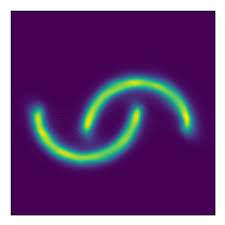</td>
    <td><img src="https://1.bp.blogspot.com/-_mAChw7K2jI/XSDymvBPUbI/AAAAAAAARdc/clDlJ92t4cM9Hf4_6uvZninyH7G4cj8EACLcBGAs/s1600/forward.gif" width="300"/></td>
    <td><img src="https://media0.giphy.com/media/WOl7Ps15yEJ0qzcjTq/giphy.gif?cid=790b7611c8931de9be027920509e4ed36bb7b46efd413b83&rid=giphy.gif&ct=g" width="300"/></td>
</tr></table>

## The loss function: maximum likelihood

Being available, the log-evidence can be maximized:

$$\large
\begin{eqnarray}
\log p_\mathcal{X}(\{x_i\}) 
&=& \log \prod_ip_\mathcal{X}(x_i) \\
&=& \log \prod_ip_\mathcal{Z}(f(x_i))|\det\left[Jf(x_i)\right]| \\
&=& \log \prod_ip_\mathcal{Z}\left(f(x_i)\right)\prod_k\left|\det\left[Jf_k(x_i)\right]\right| \\
&=& \sum_i\log\left[p_\mathcal{Z}\left(f(x_i)\right)\prod_k\left|\det\left[Jf_k(x_i)\right]\right|\right] \\
&=& \sum_i\log p_\mathcal{Z}\left(f(x_i)\right)+\log\prod_k\left|\det\left[Jf_k(x_i)\right]\right| \\
&=& \sum_i\log p_\mathcal{Z}\left(f(x_i)\right)+\sum_k\log\left|\det\left[Jf_k(x_i)\right]\right| \\
\end{eqnarray}
$$

If $p_\mathcal{Z}$ is a __standard normal__ and $\theta$ are the parameters controlling the shape of $f$:

$$\large
\begin{eqnarray}
&&\arg\max_\theta\sum_i\log p_\mathcal{Z}\left(f_\theta(x_i)\right)+\sum_k\log\left|\det\left[Jf_{\theta k}(x_i)\right]\right| \\
&&\arg\max_\theta\sum_i\log e^{-\frac{1}{2}\left\|f_\theta(x_i)\right\|^2}+\sum_k\log\left|\det\left[Jf_{\theta k}(x_i)\right]\right| \\
&&\arg\min_\theta\sum_i\frac{1}{2}\left\|f_\theta(x_i)\right\|^2-\sum_k\log\left|\det\left[Jf_{\theta k}(x_i)\right]\right| = \mathcal{L}(\theta)\\
\end{eqnarray}
$$

## The loss function: KL-divergence minimization

The same maximum likelihood result can be obtained minimizing the KL divergence:
$$\large
\begin{eqnarray} 
\arg\min_\theta &KL&\left(p_\mathcal{X}(x)||p_\mathcal{X}(f^{-1}_\theta(z))\right) \\
&=& \arg\min_\theta\mathbb{E}_\mathcal{X}\left[\log\frac{p_\mathcal{X}(x)}{p_\mathcal{X
}(f^{-1}_\theta(z))}\right] \\
&=& \arg\min_\theta\mathbb{E}_\mathcal{X}\left[\log p_\mathcal{X}(x) -\log p_\mathcal{X}(f^{-1}_\theta(z))\right] \\
&=& \arg\min_\theta - \mathbb{E}_\mathcal{X}\left[\log p_\mathcal{X}(f^{-1}_\theta(z))\right] \\
&=& \arg\min_\theta - \mathbb{E}_\mathcal{X}\left[\log p_\mathcal{Z}(f_\theta(f^{-1}_\theta(z))) + \log|\det Jf|\right] \\
&\approx& \arg\max_\theta \sum_i\left[\log p_\mathcal{Z}(f_\theta(x_i)) + \log|\det Jf|\right] \\
\end{eqnarray}
$$

## Efficient computation

To this aim, the chosen $f$ must have:

- a fast to compute Jacobian determinant;
- a closed-form or fast inverse computation.

### Good Jacobians

$\newcommand{\der}[2]{\frac{\partial f_#1}{\partial z_#2}}$

$$\large\text{Diagonal:}\qquad
J = \begin{pmatrix}
\der{1}{1} & 0 & \cdots & 0 \\
0 & \der{2}{2} & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & \der{K}{K} \\
\end{pmatrix}\qquad
\det J = \prod_k\der{k}{k}
$$

$$\large\text{Triangular:}\qquad
J = \begin{pmatrix}
\der{1}{1} & 0 & \cdots & 0 \\
\der{2}{1} & \der{2}{2} & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
\der{K}{1} & \der{K}{2} & \cdots & \der{K}{K} \\
\end{pmatrix}\qquad
\det J = \prod_k\der{k}{k}
$$

$$\large\text{Block-diagonal:}\qquad
J = \begin{pmatrix}
\der{1}{1} & \der{1}{2} & 0 & 0 \\
\der{2}{1} & \der{2}{2} & 0 & 0 \\
0 & 0 & \der{3}{3} &  0 \\
0 & 0 & 0 & \der{K}{K} \\
\end{pmatrix}\qquad
\det J = \prod_b\det{B_b}
$$

## Linear flows

The simpler parametric map is:

$\newcommand{\vec}[1]{\mathbf{\bar{#1}}}$

$$\Large
f(\vec{x}) = A\vec{x} + b \qquad \det\left(\frac{\partial f}{\partial \vec{x}}\right) = det(A)
$$

NOTEs:
- <h3> - Slow Jacobian determinant computation (given a general matrix A).</h3>
- <h3> + Given $A$ diagonal, both inverse and $\det J$ are efficient, but can be useful just for normalizations.</h3>
- <h3> + Given $A$ triangular, it becomes efficient $\det J$ and acceptable the inverse, more expressive than diagonal.</h3>
- <h3> - Not a general flow: closed under composition (eg.: maps normal to normal).</h3>

## Resudual flows

Both the following flows follow the __residual__ neural network pattern:

$$\Large
f(\vec{x}) = \vec{x} + g(\vec{x})
$$

where $g(\cdot)$ is another normalizing flow.

## Planar flows

Represents a local translation parametric map:

$\newcommand{\vec}[1]{\mathbf{\bar{#1}}}$

$$\Large
f(\vec{x}) = \vec{x} + \vec{u} h(\vec{w}^T \vec{x} + b)
$$

where $u$ and $w$ are parameter vectors, $b$ is a scalar parameter, and $h$ is an activation function.  
This corresponds to a single neuron hidden layer.

Its Jacobian determinant is:

$$\Large
\det\left(\frac{\partial f}{\partial \vec{x}}\right) = 
1 + \vec{w}^T\vec{u}h'(\vec{w}^T\vec{x}+b)
$$

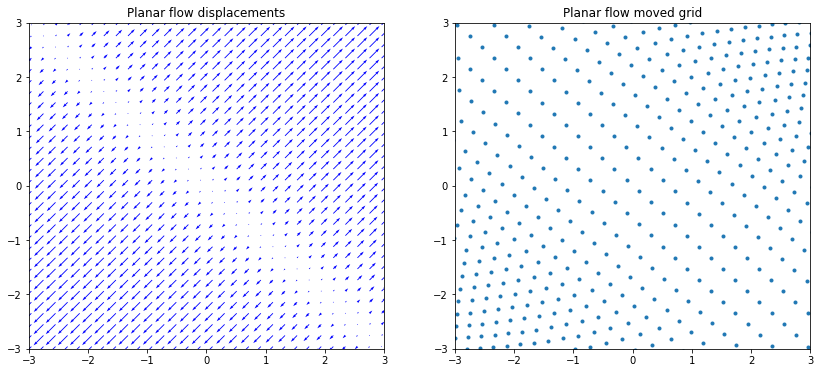

In [6]:
import numpy as np
from matplotlib import pyplot as plt

u, w, b = [[1],[1]], (1,1), 0
f = lambda x: x + u * np.arctan(np.dot(w,x) + b)

r = np.linspace(-5,5,50)
X,Y = np.meshgrid(r,r)
X,Y = X.reshape(-1), Y.reshape(-1)
XY = np.vstack((X,Y))

Z = f(XY)

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.quiver(X,Y,Z[0]-X,Z[1]-Y, scale=5e+1, color='b')
plt.title('Planar flow displacements')
plt.xlim(-3,3)
plt.ylim(-3,3)

plt.subplot(1,2,2)
plt.scatter(Z[0], Z[1], marker='.')
plt.title('Planar flow moved grid')
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.show();

NOTEs:
- <h3>+Jacobian determinant very efficient to compute.</h3>
- <h3>-Neither inverse in closed form nor inverse at all for some choices of $h$ and parameter settings.</h3>

## Radial flows

Represents a local expansion/contraction parametric map:

$$\Large
f(\vec{x}) = \vec{x} + \frac{b (\vec{x} - \vec{x}_0)}{a + \|\vec{x} - \vec{x}_0\|}
$$

NOTEs:
- <h3>+ Fast $\det J$ computation (see <a href="https://arxiv.org/pdf/1505.05770.pdf">here</a>).</h3>
- <h3>- No inverse in closed form.</h3>

## Example

Let's implement planar flows and work on normalizing the moons.

In [1]:
from sklearn.datasets import make_moons
from matplotlib import pyplot as plt

xs, ys = make_moons(n_samples=1000,noise=0.1)

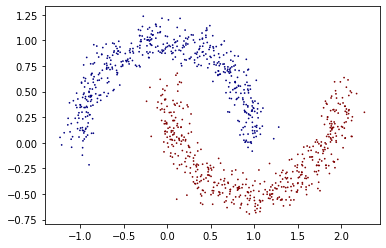

In [5]:
plt.figure(figsize=(6,4))
plt.scatter(xs[:,0],xs[:,1],marker='.', c=ys, s=2, cmap='jet')
plt.show();

In [11]:
from torch import Tensor, mm, dot, cosh, randn
from torch.nn import Module, Tanh
from torch.nn.parameter import Parameter

class PlanarFlow(Module):
    def __init__(self, dim: int, init_scale: float = .1):
        super().__init__()
        self._u = Parameter(randn(dim)*init_scale)
        self._w = Parameter(randn(dim)*init_scale)
        self._b = Parameter(randn(1)*init_scale)
        self._h = Tanh()
        
    def forward(self, x: Tensor) -> Tensor:
        return x + self._u * self._h(mm(x, self._w.reshape(-1,1)) + self._b)
    
    def det_J(self, x: Tensor) -> Tensor:
        return 1 + dot(self._u, self._w) * self._dh(mm(x, self._w.reshape(-1,1))[:,0] + self._b)
    
    def _dh(self, x: Tensor) -> Tensor:
        """D(tanh) = 1/cosh^2"""
        return 1 / cosh(x)**2

In [12]:
from typing import Sequence, Tuple
import torch
from torch.nn import ModuleList

class NfLoss(Module):
    def __init__(self, flows: Sequence[PlanarFlow]):
        super().__init__()
        self._flows = ModuleList(flows)
        
    def forward(self, x: Tensor) -> Tuple[Tensor,Tensor]:
        tot = 0
        for flow in self._flows:
            detJ = flow.det_J(x)
            tot -= torch.log(torch.abs(detJ))
            x = flow(x)
        
        tot += 0.5 * torch.sum(x ** 2, dim=1)
        return tot.sum(), x

In [13]:
from typing import Tuple
from torch import tensor
from torch.optim import Adam
from torch.nn import ModuleList

def create_model(stages: int = 8, constructor = PlanarFlow) -> ModuleList:
    return ModuleList([constructor(2) for _ in range(stages)])

def train(model: ModuleList, epochs: int = 20000):
    loss = NfLoss(model)
    data = tensor(xs).to(dtype=torch.float32)
    opt = Adam(model.parameters(), lr=1e-3)

    model.train()
    losses = []
    for epoch in range(epochs):
        opt.zero_grad()
        model.zero_grad()
        l, _ = loss(data)
        l.backward()
        opt.step()

        losses.append(l.item())
        if epoch % 1000 == 0:
            print(f"epoch: {epoch}\tloss: {l.item()}")
    
    return model, losses

In [6]:
model, losses = train(create_model(stages=8))

epoch: 0	loss: 677.5451049804688
epoch: 1000	loss: 90.62387084960938
epoch: 2000	loss: 86.55635833740234
epoch: 3000	loss: 84.45209503173828
epoch: 4000	loss: 9.39881706237793
epoch: 5000	loss: -453.2877502441406
epoch: 6000	loss: -529.3468627929688
epoch: 7000	loss: -584.173583984375
epoch: 8000	loss: -613.0166625976562
epoch: 9000	loss: -628.9571533203125
epoch: 10000	loss: -636.8283081054688
epoch: 11000	loss: -642.5036010742188
epoch: 12000	loss: -647.4099731445312
epoch: 13000	loss: -1169.912841796875
epoch: 14000	loss: -1247.915771484375
epoch: 15000	loss: -1263.5303955078125
epoch: 16000	loss: -1271.4595947265625
epoch: 17000	loss: -1276.1767578125
epoch: 18000	loss: -1297.543212890625
epoch: 19000	loss: -1307.47119140625


In [7]:
from training import save_model
from torch.nn import Sequential

#save_model('models/nf_planar', model, losses)

In [23]:
from training import load_model

model, losses = load_model('models/nf_planar_ok2', create_model(stages=8))

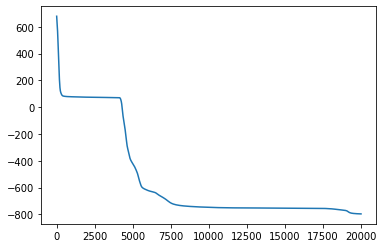

In [24]:
from matplotlib import pyplot as plt

plt.figure()
plt.plot(losses)
plt.show();

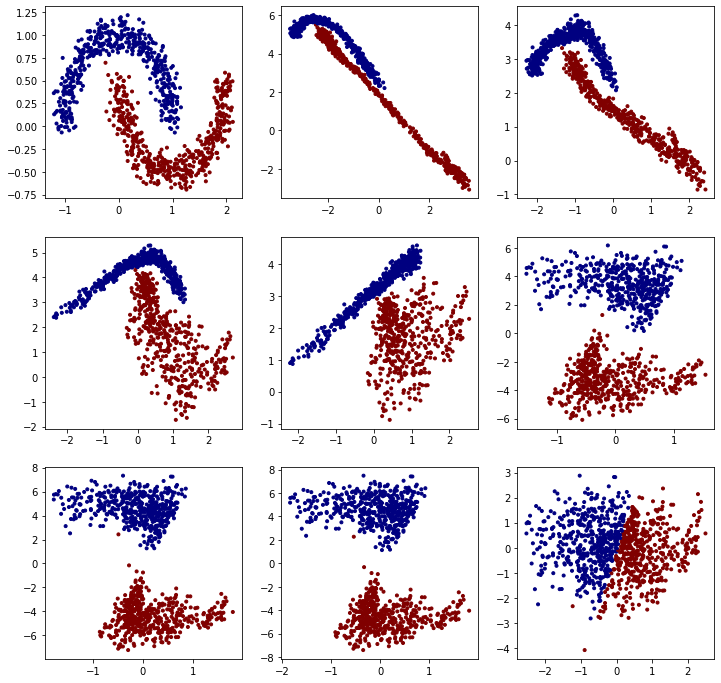

In [25]:
from math import ceil
import numpy as np

def plot_bystage_mapping(model, xs):
    with torch.no_grad():
        z = tensor(xs).to(dtype=torch.float32)
        zs = [z]
        for flow in model:
            z = flow(z)
            zs.append(z.numpy())

    C = ceil(np.sqrt(len(zs)))
    R = ceil(len(zs)/C)
    fig, ax = plt.subplots(R,C, figsize=(12,12))
    ind = 0
    for axr in ax:
        for axc in axr:
            if ind >= len(zs): break
            axc.scatter(zs[ind][:,0],zs[ind][:,1], marker='.', c=ys, cmap='jet')
            ind += 1
    plt.show();
    
    return zs

zs = plot_bystage_mapping(model, xs)

In [26]:
import numpy as np
import torch
from torch import tensor

# The grid:
gy, gx = np.meshgrid(np.linspace(-3,3,100),np.linspace(-3,3,100))
shy, gy = gy.shape, tensor(gy).reshape(-1)
shx, gx = gx.shape, tensor(gx).reshape(-1)
grid = torch.stack((gx,gy),dim=1)

# The morphed grid:
with torch.no_grad():
    z = grid.to(dtype=torch.float32)
    for flow in model:
        z = flow(z)

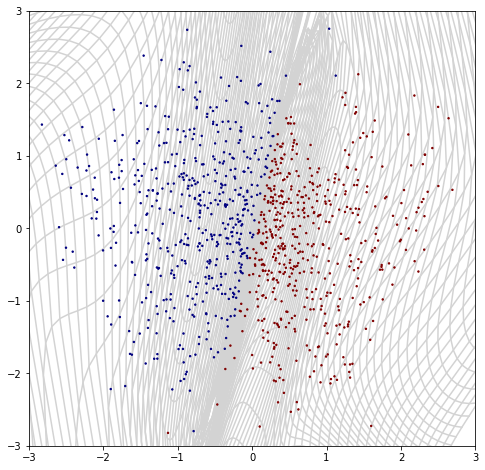

In [18]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8,8))
zgy, zgx = z[:,1].reshape(shy), z[:,0].reshape(shx)
for r in range(len(zgy)):
    plt.plot(zgx[r,:], zgy[r,:], 'lightgray', zorder=1)
    plt.plot(zgx[:,r], zgy[:,r], 'lightgray', zorder=1)
plt.scatter(zs[-1][:,0], zs[-1][:,1], s=2, c=ys, cmap='jet', zorder=2)
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.show();

### Loss sign and non-invertible flows

1. The loss represents the __negative log evidence__.. can its sign be negative?

2. Some training generated __non-ivertible flows__, can you see why the following can be non-invertible?

$$\Large
f(\vec{x}) = \vec{x} + \vec{u} \tanh(\vec{w}^T \vec{x} + b)
$$

See ["Variational Inference with Normalizing Flows"](https://arxiv.org/pdf/1505.05770.pdf), sec. "A.1".

Es an exercise, lets change the planar flow to enforce invertibility.

In [33]:
class PlanarFlow2(PlanarFlow):
    def __init__(self, dim: int, init_scale: float = .1):
        super().__init__(dim, init_scale)
        
    def forward(self, x: Tensor) -> Tensor:
        u = self._u_hat()
        return x + u * self._h(mm(x, self._w.reshape(-1,1)) + self._b)
    
    def det_J(self, x: Tensor) -> Tensor:
        u = self._u_hat()
        return 1 + dot(u, self._w) * self._dh(mm(x, self._w.reshape(-1,1))[:,0] + self._b)
    
    def _u_hat(self) -> Tensor:
        def m(x: Tensor) -> Tensor:
            return torch.log(1 + torch.exp(x)) - 1
        
        wu = dot(self._u, self._w)
        ww = dot(self._w, self._w)
        return self._u + (m(wu) - wu) / ww *self._w

In [38]:
model, losses = train(create_model(stages=8, constructor=PlanarFlow2))

epoch: 0	loss: 2878.1640625
epoch: 1000	loss: 153.2066650390625
epoch: 2000	loss: -22.185028076171875
epoch: 3000	loss: -189.09368896484375
epoch: 4000	loss: -375.8455810546875
epoch: 5000	loss: -636.1670532226562
epoch: 6000	loss: -677.364501953125
epoch: 7000	loss: -705.84912109375
epoch: 8000	loss: -713.6525268554688
epoch: 9000	loss: -718.6802978515625
epoch: 10000	loss: -722.19580078125
epoch: 11000	loss: -723.9910888671875
epoch: 12000	loss: -724.9110717773438
epoch: 13000	loss: -725.4688720703125
epoch: 14000	loss: -725.846923828125
epoch: 15000	loss: -726.12939453125
epoch: 16000	loss: -726.3522338867188
epoch: 17000	loss: -726.5377807617188
epoch: 18000	loss: -726.6967163085938
epoch: 19000	loss: -726.8392333984375


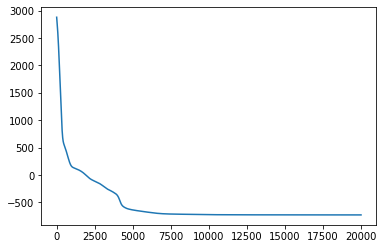

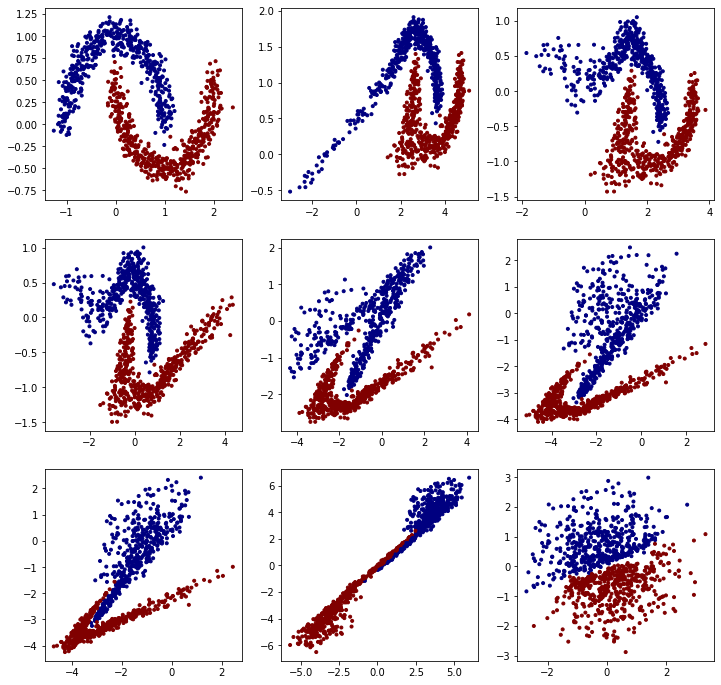

In [39]:
plt.figure()
plt.plot(losses)
plt.show()

plot_bystage_mapping(model, xs);

## Auto-Regressive flows

We wish to estimate $p(\vec{x})$, by the chain rule:

$$\Large
p(\vec{x}) = p(x_1, \cdots, x_n) = p(x_1)p(x_2, \cdots, x_n|x_1) = \prod_i p(x_i|x_{<i})
$$

Given that, the map $f$ can be defined as:

$$\Large
f(\vec{x}) =
\begin{pmatrix}
z_1\\
z_2\\
\cdots\\
z_i\\
\cdots\\
z_n\\
\end{pmatrix} =
\begin{pmatrix}
f_1(x_1)\\
f_2(x_1, x_2)\\
\cdots\\
f_i(x_{\leq i})\\
\cdots\\
f_n(\vec{x})\\
\end{pmatrix} =
\begin{pmatrix}
f_1(x_1)\\
f_2(z_1, x_2)\\
\cdots\\
f_i(z_{i-1}, x_i)\\
\cdots\\
f_n(z_{n-1}, x_n)\\
\end{pmatrix}
$$

A schema representing AR forward and inverse computation:

<img src="images/ARFlows.png" width="750"/>
<center><a href="https://arxiv.org/pdf/1912.02762.pdf">Normalizing Flows for Probabilistic Modeling and Inference</a></center>

the inverse can be written as:

$$\Large
f^{-1}(\vec{z}) =
\begin{pmatrix}
x_1\\
x_2\\
\cdots\\
x_i\\
\cdots\\
x_n\\
\end{pmatrix} =
\begin{pmatrix}
f_1^{-1}(z_1)\\
f_2^{-1}(z_1, z_2)\\
\cdots\\
f_i^{-1}(z_{i-1}, z_i)\\
\cdots\\
f_n^{-1}(z_{n-1}, z_n)\\
\end{pmatrix}
$$

Notice that the Jacobian is triangular, thus:

$$\Large
\det\left(\frac{\partial f}{\partial \vec{x}}\right) = 
\prod_i\frac{\partial f_i}{\partial x_i}
$$

### Universality of AR flows

> Theorem:  
> Given two pdfs $\mu$ and $\rho$, there always exist a unique increasing triangular map $f$ that transforms $\mu$ to $\rho$.  
> (for a fixed variable ordering)

See [Triangular Transformations of Measures](https://bibos.math.uni-bielefeld.de/preprints/04-10-159.pdf).

- <h3>+ expressive (composed) map</h3>
- <h3>+ fast det-J computation</h3>
- <h3>+ invertible if the $f_i$ are invertible</h3>
- <h3>- slow inverse computation</h3>
- <h3>- internal representational power required to $f_i$s are different</h3>

### Permutations

To solve the representational power issue:

- stratify many AR maps
- interleave them with permutations

## Coupling Flows, [NICE, Apr 2015](https://arxiv.org/pdf/1410.8516.pdf)

> How can we insert an arbitrary computation keeping invertibility and ease of Jacobian determinant computation?

<img src="https://tech.skit.ai/assets/images/posts/normalizing-flows/coupling_flows.png" width="600"/>
<center><a href="https://arxiv.org/pdf/1908.09257.pdf">Normalizing Flows: An Introduction and Review of Current Methods</a></center>

The map of case _a_ becomes:

$$\Large
\newcommand{\pair}[2]{\begin{pmatrix}#1\\#2\end{pmatrix}}
f(\vec{x}) = f\pair{x^A}{x^B} = \pair{h_\theta\left(x^A\right)}{x^B} = \pair{h_{\Theta(x^B)}\left(x^A\right)}{x^B} = \pair{y^A}{y^B}
$$

where $h$ must be invertible and $\Theta$ is arbitrary computation (e.g.: a Neural Network).

The inverse is:

$$\Large
\newcommand{\pair}[2]{\begin{pmatrix}#1\\#2\end{pmatrix}}
f^{-1}(\vec{y}) = f^{-1}\pair{y^A}{y^B} = \pair{h^{-1}_\theta\left(y^A\right)}{y^B} = \pair{h^{-1}_{\Theta(y^B)}\left(y^A\right)}{y^B} = \pair{x^A}{x^B}
$$

The Jacobian determinant is that of $h$, since on the $B$ part the map is identical.

The case _b_ emulates **hierarchical processing** like in UNet architectures.

> Functions to choose are:
> - the **coupling function** $h(\cdot)$;
> - AND the **conditioner function** $\Theta(\cdot)$.

> **Splitting strategies** becomes a central concern.

NOTE: Conditional normalizing flows.

### [Universality of Coupling flows, Feb 2022](https://arxiv.org/pdf/2202.02906.pdf)

> A single coupling flow is not an universal approximator.

Stacking many coupling flows using affine coupling functions and invertible linear transforms is universal.

## [RealNVP (Non Volume Preserving flows), Feb 2017](https://arxiv.org/pdf/1605.08803.pdf)

### Affine coupling layers

$$\Large
f(\vec{x}) =
\begin{pmatrix}
z_{1..d} \\
z_{d+1..D} \\
\end{pmatrix} =
\begin{pmatrix}
x_{1..d} \\
x_{d+1..D} \odot e^{s(x_{1..d})} + t(x_{1..d}) \\
\end{pmatrix}
$$

with $s(\cdot)$ and $t(\cdot)$ implemented as __deep neural networks__.

The jacobian is triangular, thus:

$$\Large
\DeclareMathOperator{\diag}{diag}
\det Jf = \prod\diag e^{s(x_{1..d})} = e^{\sum\diag s(x_{1..d})}
$$

### Masking

To separate $x_{1..d}$ from $x_{d+1..D}$ a mask $b$ is used:

$$\Large
f(\vec{x}) = \left[b \odot \vec{x}\right] + \left[(1-b) \odot \vec{x}\right] \odot e^{s(\left[b \odot \vec{x}\right])} + t(\left[b \odot \vec{x}\right])
$$

where:

$$\Large
\begin{eqnarray}
x_{1..d} &=& \left[b \odot \vec{x}\right] \\
x_{d+1..D} &=& \left[(1-b) \odot \vec{x}\right] \\
\end{eqnarray}
$$

### Multiscale architecture

Many resolution levels allow bottom-up "gaussianization":

$$\Large
\begin{pmatrix}
    \vec{1} & 2 & \vec{3} & 4 \\
    5 & \vec{6} & 7 & \vec{8} \\
    \vec{9} & 10 & \vec{11} & 12 \\
    13 & \vec{14} & 15 & \vec{16} \\
\end{pmatrix}
\Rightarrow
\underbrace{
    \begin{pmatrix}
        \vec{1} & \vec{3} \\
        \vec{9} & \vec{11} \\
    \end{pmatrix},
    \begin{pmatrix}
        \vec{6} & \vec{8} \\
        \vec{14} & \vec{16} \\
    \end{pmatrix},
}_\text{x_{1..d}}
\underbrace{
    \begin{pmatrix}
        2 & 4 \\
        10 & 12 \\
    \end{pmatrix},
    \begin{pmatrix}
        5 & 7 \\
        13 & 15 \\
    \end{pmatrix}
}_\text{x_{d+1..D}}
$$

### Coupling layer composition scheme

Alternated processing of 2 variable groups:

<img src="images/RealNVP.png" width="700"/>
<center><a href="https://arxiv.org/pdf/1605.08803.pdf">Density Estimation using Real NVP</a></center>

## [Glow, Jul 2018](https://arxiv.org/pdf/1807.03039.pdf)

- Evolution of RealNVP.
- Introduces the __1x1 invertible convolutions__.

### 1x1 invertible convolutions

- 1x1 convolutions are linear transformations on channels (generalization of permutation).
- Calling $W$ the transformation matrix, then $\det J = \det W$  
  (cubic in the number of channels, can be linear parameterizing $W = PL(U+\diag(s)$).
- Initialized as random rotation, invertibility not forced otherwise.

### Results

<img src="images/Glow_results.png" size="750"/>
<center><a href="https://arxiv.org/pdf/1807.03039.pdf">Glow: Generative Flow with Invertible 1×1 Convolutions</a></center>

## Normalizing flows and autoencoders

How can a NF be exploited in autoencoders?

__Force by design the distribution in the bottleneck.__

In [179]:
from typing import List, Tuple
import torch
from torch.nn import Sequential, Linear, LeakyReLU, ReLU
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from dataset import load_mnist, PairDataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

class MLP(Sequential):
    def __init__(self, layers: List[int]):
        super().__init__(*[
            Sequential(
                Linear(layers[i-1],layers[i]),
                LeakyReLU(),
            ) for i in range(1,len(layers))
        ])
        
class NfAutoencoder(Module):
    def __init__(
        self, 
        encoder: List[int], 
        flows: int, 
        decoder: List[int],
    ):
        super().__init__()
        self.encoder = MLP(encoder)
        self.flows = NfLoss([PlanarFlow2(2) for _ in range(flows)])
        self.decoder = MLP(decoder)
    
    def forward(self, img: Tensor) -> Tuple[Tensor, Tensor]:
        x = self.encoder(img.reshape(-1, 28**2))
        neg_log_p, z = self.flows(x)
        res = self.decoder(z).reshape(img.shape)
        return res, neg_log_p

def train2(
    model: NfAutoencoder, 
    epochs: int = 100
):
    opt = Adam(model.parameters(), lr=1e-2)
    scheduler = ExponentialLR(opt, gamma=0.8)
    data = DataLoader(
        PairDataset(load_mnist(train=True)[0]), 
        batch_size=64, shuffle=True)

    model.train()
    neg_log_ps, mses, losses = [], [], []
    relu = ReLU()
    for epoch in range(epochs):
        for x_in, x_gt in tqdm(data):
            opt.zero_grad()
            model.zero_grad()
            
            x_out, neg_log_p = model(x_in)
            mse = torch.mean((x_out-x_gt)**2)
            loss = (neg_log_p/1000).sigmoid() * mse
            
            loss.backward()
            opt.step()

            neg_log_ps.append(neg_log_p.item())
            mses.append(mse.item())
            losses.append(loss.item())
            
        scheduler.step()
        print(f"epoch: {epoch}\tloss: {losses[-1]}")
    
    return model, {"neg_log_ps":neg_log_ps, "mses":mses, "losses":losses}

mnist_model_params = ([28**2, 64, 16, 2], 40, [2, 16, 64, 28**2])
mnist_model, mnist_losses = train2(NfAutoencoder(*mnist_model_params))

  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 0	loss: 0.023021388798952103


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 1	loss: 0.021903054788708687


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 2	loss: 0.018457628786563873


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 3	loss: 0.021930258721113205


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 4	loss: 0.023405101150274277


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 5	loss: 0.020713888108730316


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 6	loss: 0.020936882123351097


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 7	loss: 0.01799640990793705


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 8	loss: 0.017387354746460915


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 9	loss: 0.01663081906735897


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 10	loss: 0.01776215434074402


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 11	loss: 0.01963876187801361


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 12	loss: 0.01791529357433319


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 13	loss: 0.017411453649401665


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 14	loss: 0.017349764704704285


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 15	loss: 0.01702737621963024


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 16	loss: 0.01608346775174141


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 17	loss: 0.018519029021263123


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 18	loss: 0.01773260533809662


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 19	loss: 0.017685987055301666


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 20	loss: 0.01721116341650486


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 21	loss: 0.017341459169983864


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 22	loss: 0.016332807019352913


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 23	loss: 0.016237083822488785


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 24	loss: 0.016295334324240685


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 25	loss: 0.016800273209810257


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 26	loss: 0.018271174281835556


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 27	loss: 0.018116574734449387


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 28	loss: 0.015882015228271484


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 29	loss: 0.016321932896971703


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 30	loss: 0.019197650253772736


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 31	loss: 0.015875257551670074


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 32	loss: 0.018992334604263306


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 33	loss: 0.01881076954305172


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 34	loss: 0.01817937195301056


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 35	loss: 0.01706589199602604


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 36	loss: 0.01836775802075863


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 37	loss: 0.016494078561663628


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 38	loss: 0.017758848145604134


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 39	loss: 0.016141554340720177


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 40	loss: 0.020462874323129654


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 41	loss: 0.016873231157660484


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 42	loss: 0.017358824610710144


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 43	loss: 0.016926515847444534


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 44	loss: 0.015629731118679047


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 45	loss: 0.01644469052553177


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 46	loss: 0.019443953409790993


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 47	loss: 0.018771138042211533


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 48	loss: 0.016530916094779968


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 49	loss: 0.01774747297167778


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 50	loss: 0.016372116282582283


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 51	loss: 0.01646598055958748


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 52	loss: 0.01569235324859619


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 53	loss: 0.01503968145698309


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 54	loss: 0.016551967710256577


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 55	loss: 0.015200628899037838


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 56	loss: 0.015727344900369644


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 57	loss: 0.018503693863749504


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 58	loss: 0.017181089147925377


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 59	loss: 0.018535567447543144


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 60	loss: 0.018254075199365616


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 61	loss: 0.016701150685548782


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 62	loss: 0.013881377875804901


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 63	loss: 0.01740626059472561


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 64	loss: 0.02054646983742714


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 65	loss: 0.01770094782114029


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 66	loss: 0.015237799845635891


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 67	loss: 0.014800476841628551


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 68	loss: 0.0169519055634737


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 69	loss: 0.01521323062479496


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 70	loss: 0.015348383225500584


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 71	loss: 0.017594898119568825


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 72	loss: 0.016563229262828827


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 73	loss: 0.016078675165772438


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 74	loss: 0.01768157072365284


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 75	loss: 0.015143558382987976


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 76	loss: 0.017276832833886147


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 77	loss: 0.016788410022854805


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 78	loss: 0.015813827514648438


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 79	loss: 0.015627682209014893


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 80	loss: 0.01574653759598732


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 81	loss: 0.016181832179427147


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 82	loss: 0.017055822536349297


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 83	loss: 0.017077317461371422


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 84	loss: 0.019130636006593704


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 85	loss: 0.016235698014497757


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 86	loss: 0.018671927973628044


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 87	loss: 0.01991165243089199


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 88	loss: 0.01597132906317711


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 89	loss: 0.018027648329734802


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 90	loss: 0.016205573454499245


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 91	loss: 0.01429660338908434


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 92	loss: 0.01570942811667919


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 93	loss: 0.01591813564300537


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 94	loss: 0.017852313816547394


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 95	loss: 0.017132524400949478


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 96	loss: 0.015866391360759735


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 97	loss: 0.014823731034994125


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 98	loss: 0.013749110512435436


  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 99	loss: 0.015280638821423054


In [180]:
from training import save_model
save_model('models/nf_ae', mnist_model, mnist_losses)

In [176]:
from training import load_model
mnist_model, mnist_losses = load_model('models/nf_ae', NfAutoencoder(*mnist_model_params))

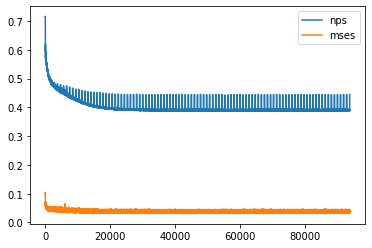

In [182]:
from matplotlib import pyplot as plt
import numpy as np

neg_log_ps, mses, losses = mnist_losses.values()

def sigmoid(x):
    return 1 /(1+np.exp(-x))

plt.figure()
plt.plot(sigmoid(np.array(neg_log_ps)/1000))
plt.plot(mses)
plt.legend(["nps", "mses"])
plt.show();

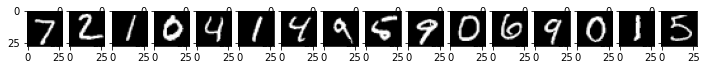

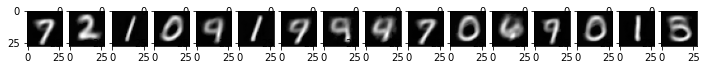

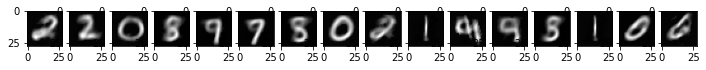

In [178]:
from torch import no_grad

with no_grad():
    mnist_test, _ = load_mnist(train=False)
    x = mnist_test[:16,:,:].reshape(16,1,28,28)
    x_hat, _ = mnist_model(x)

def show_samples(x_hat):
    plt.figure(figsize=(12,4))
    for i in range(x_hat.shape[0]):
        plt.subplot(1,x_hat.shape[0],i+1)
        plt.imshow(x_hat[i,...].reshape(28,28), cmap='gray')
    plt.show();

show_samples(x)
show_samples(x_hat)

with no_grad():
    show_samples(mnist_model.decoder(torch.randn(16,2)))

## Some other references

- [Variational Inference with Normalizing Flows, 2016](https://arxiv.org/pdf/1505.05770.pdf)
- [Normalizing Flows: An Introduction and Review of Current Methods, 2020](https://arxiv.org/pdf/1908.09257.pdf)
- [Neural Autoregressive Flows, Apr 2018](https://arxiv.org/pdf/1804.00779.pdf)
- [MAF (Masked Autoregressive Flows), Jun 2018](https://arxiv.org/pdf/1705.07057.pdf)
- [Neural Spline Flows, Dec 2019](https://arxiv.org/pdf/1906.04032.pdf)
- [SRFlow, Jul 2020](https://arxiv.org/pdf/2006.14200.pdf)
- [Stochastic Normalizing Flows (SNF), Oct 2020](https://arxiv.org/pdf/2002.06707.pdf)
- [Normalizing Flows for Probabilistic Modeling and Inference, 2021](https://arxiv.org/pdf/1912.02762.pdf)
- [Universality of Coupling flows, Feb 2022](https://arxiv.org/pdf/2202.02906.pdf)